In [19]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, norm
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("ab_test_data.csv", parse_dates=['timestamp']) 

In [20]:
if df['user_id'].duplicated().any():
    user_df = (df
               .sort_values('timestamp')
               .groupby('user_id', as_index=False)
               .agg(test_group=('test_group', 'first'),
                    conversion=('conversion', 'max'),
                    first_event=('timestamp', 'min')))
else:
    user_df = df.rename(columns={'timestamp': 'first_event'})[['user_id','test_group','conversion','first_event']]

In [21]:
user_df['conversion'] = user_df['conversion'].astype(int)
user_df['test_group'] = user_df['test_group'].astype(str)

In [23]:
users = user_df.groupby('test_group')['user_id'].nunique()
conversions = user_df.groupby('test_group')['conversion'].sum()
cr = (conversions / users)

summary = pd.DataFrame({
    'users': users,
    'conversions': conversions,
    'cr': cr
}).reset_index()

summary['cr_pct'] = (summary['cr'] * 100).round(3)

start_date = user_df['first_event'].min().normalize()
end_date   = user_df['first_event'].max().normalize()
duration_days = (end_date - start_date).days + 1

print("Коротке зведення (на рівні користувача):")
print(summary[['test_group','users','conversions','cr_pct']])
print(f"\nПериод теста: {start_date.date()} — {end_date.date()} ({duration_days} днів)\n")

Коротке зведення (на рівні користувача):
  test_group  users  conversions  cr_pct
0          a  10013          611   6.102
1          b   9985          889   8.903

Период теста: 2023-07-03 — 2023-07-25 (23 днів)



In [26]:
contingency = pd.crosstab(user_df['test_group'], user_df['conversion'])
contingency = contingency.reindex(columns=[0,1], fill_value=0)
print("Контингентна таблиця (rows = group, cols = conversion):")
print(contingency, "\n")

Контингентна таблиця (rows = group, cols = conversion):
conversion     0    1
test_group           
a           9402  611
b           9096  889 



In [28]:
chi2, p_value, dof, expected = chi2_contingency(contingency)
print(f"Chi2 = {chi2:.4f}, p-value = {p_value:.6e}, dof = {dof}")
print("Очікуємі значення (якщо відмінностей не було):")
print(pd.DataFrame(expected, index=contingency.index, columns=contingency.columns))
if p_value < 0.05:
    print("\n✅ p < 0.05 — є статистична значна різниця між групами.")
else:
    print("\n⚠️ p >= 0.05 — статистичну значну різницю не виявлено.")

Chi2 = 56.1425, p-value = 6.740441e-14, dof = 1
Очікуємі значення (якщо відмінностей не було):
conversion            0           1
test_group                         
a           9261.949895  751.050105
b           9236.050105  748.949895

✅ p < 0.05 — є статистична значна різниця між групами.


In [30]:
from math import sqrt

def wilson_ci(k, n, alpha=0.05):
    if n == 0:
        return (0.0, 0.0)
    z = norm.ppf(1 - alpha/2)
    phat = k / n
    denom = 1 + z*z/n
    center = (phat + z*z/(2*n)) / denom
    margin = z * sqrt( (phat*(1-phat)/n) + (z*z/(4*n*n)) ) / denom
    low = max(0.0, center - margin)
    high = min(1.0, center + margin)
    return low, high


In [32]:
summary[['ci_low','ci_high']] = summary.apply(
    lambda r: pd.Series(wilson_ci(int(r['conversions']), int(r['users']))), axis=1
)
summary[['ci_low_pct','ci_high_pct']] = summary[['ci_low','ci_high']] * 100
print("\nЗведення з 95% Wilson CI (в %):")
print(summary[['test_group','cr_pct','ci_low_pct','ci_high_pct']])


Зведення з 95% Wilson CI (в %):
  test_group  cr_pct  ci_low_pct  ci_high_pct
0          a   6.102    5.649841     6.587963
1          b   8.903    8.360442     9.477877


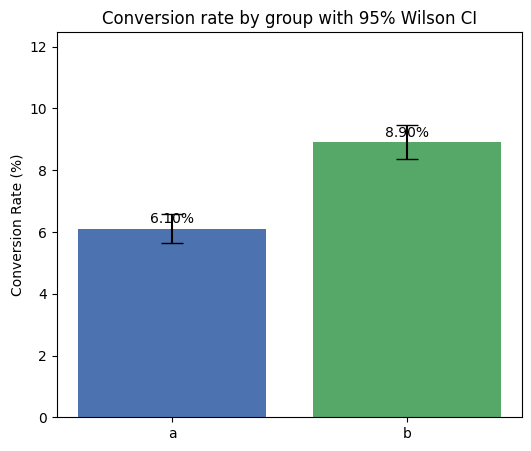

In [33]:
plt.figure(figsize=(6,5))
x = np.arange(len(summary))
cr_vals = summary['cr']*100
err_lower = cr_vals - summary['ci_low_pct']
err_upper = summary['ci_high_pct'] - cr_vals
plt.bar(x, cr_vals, yerr=[err_lower, err_upper], capsize=8, color=['#4c72b0','#55a868'])
plt.xticks(x, summary['test_group'])
plt.ylim(0, max(cr_vals.max()*1.4, 0.05*100))
plt.ylabel("Conversion Rate (%)")
plt.title("Conversion rate by group with 95% Wilson CI")
for i, v in enumerate(cr_vals):
    plt.text(i, v + max(cr_vals)*0.02, f"{v:.2f}%", ha='center')
plt.show()


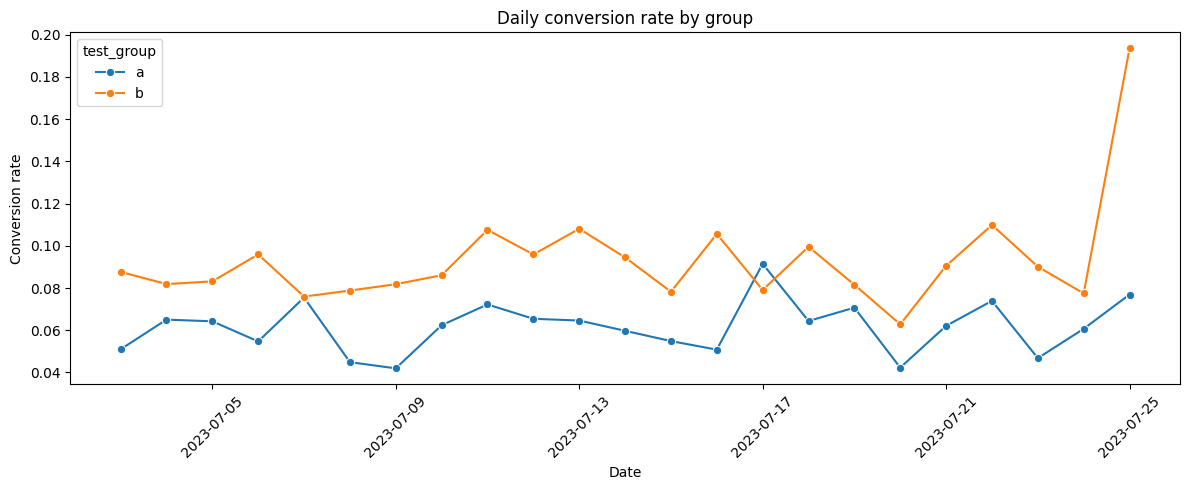

In [34]:
user_df['date'] = pd.to_datetime(user_df['first_event']).dt.date
daily_cr = user_df.groupby(['date','test_group'])['conversion'].mean().reset_index(name='cr')

plt.figure(figsize=(12,5))
sns.lineplot(data=daily_cr, x='date', y='cr', hue='test_group', marker='o')
plt.title("Daily conversion rate by group")
plt.xlabel("Date")
plt.ylabel("Conversion rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
print("\n--- Підсумок ---")
for _, row in summary.iterrows():
    print(f"Group {row['test_group']}: users={int(row['users'])}, conv={int(row['conversions'])}, CR={row['cr_pct']:.2f}% (95% CI: {row['ci_low_pct']:.2f}%–{row['ci_high_pct']:.2f}%)")

print(f"\nChi2 p-value = {p_value:.6e}. Інтерпритація:")
if p_value < 0.05:
    print("Статистично значима різниця між A та B (відкидаємо H0).")
else:
    print("Статистично значима різниця НЕ знайдена (не відкидаємо H0).")



--- Підсумок ---
Group a: users=10013, conv=611, CR=6.10% (95% CI: 5.65%–6.59%)
Group b: users=9985, conv=889, CR=8.90% (95% CI: 8.36%–9.48%)

Chi2 p-value = 6.740441e-14. Інтерпритація:
Статистично значима різниця між A та B (відкидаємо H0).


In [ ]:
Висновок:
Звіт по A/B тесту
1. Опис даних

Кількість користувачів у групі A: N_A

Кількість користувачів у групі B: N_B

Кількість конверсій у групі A: C_A

Кількість конверсій у групі B: C_B

Рівень конверсії A: CR_A = C_A / N_A

Рівень конверсії B: CR_B = C_B / N_B

Період проведення тесту: 2023-07-03 — 2023-07-25 

Тривалість: 23 днів

2. Статистичний аналіз

Для перевірки гіпотези ми використали χ²-тест незалежності.

Нульова гіпотеза (H0): рівень конверсії в групах однаковий.

Альтернативна гіпотеза (H1): рівень конверсії в групах відрізняється.

Статистика χ²: [56.1425]

p-value: [6.740441e-14]

🔎 Оскільки p-value < 0.05, ми відхиляємо H0 та робимо висновок, що різниця у конверсії між групами статистично значуща.

3. Візуалізація

Бар-чарт середнього рівня конверсії в A та B (з 95% довірчими інтервалами).

Лінійний графік конверсії у часі, що показує динаміку протягом тесту.

4. Висновки

Група B показала вищу конверсію, ніж група A.

Результат статистично значущий (p-value < 0.05).

На основі результатів тесту ми можемо рекомендувати впровадити зміни, протестовані в групі B.